# Fine Tuning Multiclass Classifier
### Example: Face Recognition of World Leaders

Andreu Casas and Nora Webb Williams | August, 2018

### Paths & Constants

In [5]:
#DATA_PATH is where world leaders images are (the data)

# For instructors' demo
#DATA_PATH = '/home/ubuntu/VPG/PROJECTS/cambridge_elements/data/'

# For cloned EC2 instance
DATA_PATH = '/home/ubuntu/cambridge_elements/data/'

#FUNCTIONS_PATH may also needs to change to where you've saved 00functions.py file
# - the path to a script with several FUNCTIONS we use in this script

# For instructors' demo
#FUNCTIONS_PATH = '/home/ubuntu/VPG/PROJECTS/cambridge_elements/notebooks/'

# For cloned EC2 instance
FUNCTIONS_PATH = '/home/ubuntu/cambridge_elements/notebooks/'

### Hyperparameters

In [6]:
# Which sets of data do you want to train a model for? 
# If left empty, code with train for all directories in the DATA_PATH directory
model_list = ['world_leaders']

# Fine-tuning specification
num_classes = 6 # Enter the number of classes you are training for. There are 6 World Leaders.
set_report_num = 1 # Enter how often you wish the program to report back as it iterates

# Hyperparameters
hyperparam_combo_num = 1 # Use this to keep track of which version of hyperparameters you are using 
set_learn_rate = 0.0001 # Enter the desired learning rate
set_momentum = .9 # Enter the desired momentum
set_step_size = 7 # Enter the desired step size
set_gamma = 0.1 # Enter the desired gamma
set_iterations = 20 # Enter the desired number of iterations
set_batch_size = 4 # Enter the desired batch size

### Packages

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np
plt.ion()   # interactive mode
import os
import pickle
import json
from PIL import Image
import re
import pandas as pd

### Functions

In [8]:
os.chdir(FUNCTIONS_PATH)
exec(open('00_functions.py', "rb").read())

### --MAIN-- Model Trainig

In [9]:
# - a list of models to train, if not set by researcher above
if len(model_list) == 0:
	model_list = os.listdir(DATA_PATH)
	model_list = [m for m in model_list if m not in ['.DS_Store', 'MODELS', 'ACCURACY']]
	model_list.sort()

# Since this demo has only one possible set of data, no need to loop over multiple
# models. Instead set the model_str to the first value in this
# See the 01_fine_tune_binary_models.ipynb for an example of how to modify this into a for loop
model_str = model_list[0]
    
# Specifying some objects that will be the same for trianing the 7 models
# - preprocessing to be applied to the images. See '00_functions.py' script
#   for more details on the 'data_transform()' function
preprocess = data_tranform()
# - checking if the machine has GPUs
use_gpu = torch.cuda.is_available()

# - how often (every how many iterations) should the loop print/report accuracy
report_num = set_report_num 

# Iterate through the datasets and build image classifiers.
counter_models = 0
total_models = len(model_list)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.


In [10]:
#================================================================
# INITIALIZE MODEL
#================================================================
# - load a pretrained model from TorchVision: ResNet18
model = models.resnet18(pretrained=True)

# - check number of features in last fully connected layer
num_ftrs = model.fc.in_features 

# - change the output layer from 1,000 classes to a binary outcome
model.fc = nn.Linear(num_ftrs, num_classes) # For ResNet18, last step is 512 -> 6 for multi-class

In [11]:
#================================================================
# MODEL HYPER-PARAMETERS
#================================================================
# - specify some model hyperparameters
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(model.parameters(), 
                         lr=set_learn_rate, 
                         momentum=set_momentum) # how to perform optimization
scheduler = lr_scheduler.StepLR(optimizer, 
                                       step_size=set_step_size, 
                                       gamma=set_gamma) # how to update learning rate     orginially .1

# - number of iterations
iter_num = set_iterations

In [12]:
#================================================================
# PRE-PROCESSING
#================================================================
# - update counter and report progress
counter_models += 1
print('Training Model %s of %s: %s'%(counter_models, total_models, model_str.upper()))
print('=================================\n')

# - specify the path to data for this particular classifier
model_path = '%s/%s/'%(DATA_PATH, model_str)

# - specifying where the train and test images are
image_datasets = {x: datasets.ImageFolder(os.path.join(model_path, x),
                                          preprocess[x])
                  for x in ['train', 'test']}

# - creating an object to easily load the train and test images
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size,
                                             shuffle=True)
              for x in ['train', 'test']}

# - getting some extra information such as the size of the dataset and the
#       class number
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# - specify whether to use gpu 
if use_gpu:
    model = model.cuda()

Training Model 1 of 1: WORLD_LEADERS



In [13]:
#================================================================
# MODEL ESTIMATION
#================================================================
# - check the size of the train and test sets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# - initialize a time object so we can check how long the training 
#   takes
since = time.time()

# - initialize a matrix of weights (model parameters) and accuracy
#   object where we'll save the weights and accuracy info for the
#   most accurate weights-configuration
best_model_wts = model.state_dict()
best_acc = 0.0
best_precision = 0.0
best_recall = 0.0
loss_progress = []  
acc_progress = []

# - 
for iteration in range(iter_num):
    if iteration % report_num == 0:
        print('Iteration {}/{}'.format(iteration, iter_num - 1))
        print('-' * 10)

    # - each iteration has a training and testing phase
    for phase in ['train', 'test']:
        if phase == 'train':
            scheduler.step() # update model weights
            model.train(True)  # set model to training mode
        else:
            model.train(False)  # set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        running_preds = []
        running_labels = []

        # - iterate over data: in training iteration we
        #   iterate through groups of 4 train and 4 test
        #   images.
        for data in dataloaders[phase]:
            # - get the inputs
            inputs, labels = data

            # - transform data and labels into PyTorch variables
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # - gradients back to 0 (re-calculated in each iteration)
            optimizer.zero_grad()

            # - forward propagation: applying dot products
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            preds_int_list = list(preds)
            labels_int_list = list(labels.data)                
            loss = criterion(outputs, labels)

            # (only in training phase)
            # - backward propagation: calculate loss and gradients
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # - calculate accuracy statistics
            running_loss += loss.data[0] #.item()
            running_corrects += torch.sum(preds == labels.data) #.item()
            running_preds = running_preds + preds_int_list
            running_labels = running_labels + labels_int_list

        iter_loss = running_loss / dataset_sizes[phase]
        iter_acc = running_corrects / dataset_sizes[phase]
        # - report training progress once every N (e.g. 10) iterations
        if iteration % report_num == 0:
            print('{} Loss:{:.4f} Acc:{:.4f}\n'.format(
                phase, iter_loss, iter_acc))
            
        # ... (calculating precision and recall by class)
        if phase == 'test':
            for class_i in range(0, len(class_names)):    
                labels_class_i_indices = [i for i in range(0, len(running_labels)) if running_labels[i] == class_i]
                preds_class_i_indices = [i for i in range(0, len(running_preds)) if running_preds[i] == class_i]
                correctly_recalled = [x for x in labels_class_i_indices if x in preds_class_i_indices]
                correctly_predicted = [x for x in preds_class_i_indices if x in labels_class_i_indices]
                if len(correctly_recalled) > 0:
                    class_recall = round(len(correctly_recalled) / round(len(labels_class_i_indices)), 2)
                else:
                    class_recall = 0
                if len(correctly_predicted) > 0:
                    class_precision = round(len(correctly_predicted) / round(len(preds_class_i_indices)), 2)
                else:
                    class_precision = 0
                print('... %s precision: %s | recall: %s'%(class_names[class_i], class_precision, class_recall))
            print('\n\n')

        # - if this iteration's results are the best so far,
        #   saving a copy of this best model
        if phase == 'test' and iter_acc > best_acc:
            best_acc = iter_acc
            best_model_wts = model.state_dict()                
        if phase == 'test':
            # - keep track of the evolution of the loss and accuracy
            loss_progress.append(iter_loss)
            acc_progress.append(iter_acc)

    # - if the accuracy is already pretty high, move to next
    #   classifier
    if best_acc > 0.95 and best_precision > 0.95 and best_recall > 0.95:
        print('... reached good model accuracy, moving to next model.')
        break

# - check how long it took to estimate the model and report
#   time and results for the most accurate model weights
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}\n\n'.format(best_acc))    

# - use the best model to predict labels for the whole
#   test set and calculate precision and recall of the
#   binary classifier   

# - save the best model weights and accuracy (uncomment for saving the model)
#model.load_state_dict(best_model_wts)
#torch.save(model, '%s/MODELS/%s.pth'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)))
accuracy_summary = {'acc':best_acc,
                      'precision':best_precision,
                      'recall':best_recall,
                      'lr':set_learn_rate,
                      'momentum':set_momentum,
                      'step_size':set_step_size,
                      'gamma':set_gamma,
                      'max_iters':set_iterations,
                      'batch_size':set_batch_size, 
                      'acc_progress':acc_progress,
                      'loss_progress':loss_progress
                      }

Iteration 0/19
----------
train Loss:0.4560 Acc:0.2614

test Loss:0.3337 Acc:0.5824

... ESP precision: 0.84 | recall: 0.78
... JPN precision: 0.75 | recall: 0.6
... KAZ precision: 0.6 | recall: 0.3
... USA precision: 0.22 | recall: 0.6
... VEN precision: 0.5 | recall: 0.2
... ZAF precision: 0.44 | recall: 0.4



Iteration 1/19
----------
train Loss:0.4028 Acc:0.3693

test Loss:0.2592 Acc:0.8681

... ESP precision: 0.97 | recall: 0.9
... JPN precision: 0.91 | recall: 1.0
... KAZ precision: 1.0 | recall: 0.9
... USA precision: 0.8 | recall: 0.8
... VEN precision: 1.0 | recall: 0.5
... ZAF precision: 0.56 | recall: 1.0



Iteration 2/19
----------
train Loss:0.3668 Acc:0.5021

test Loss:0.2052 Acc:0.9670

... ESP precision: 1.0 | recall: 0.98
... JPN precision: 0.91 | recall: 1.0
... KAZ precision: 1.0 | recall: 1.0
... USA precision: 0.9 | recall: 0.9
... VEN precision: 0.9 | recall: 0.9
... ZAF precision: 1.0 | recall: 1.0



Iteration 3/19
----------
train Loss:0.3118 Acc:0.6846

test

### Take a look at some model predictions

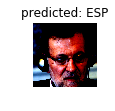

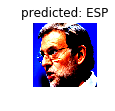

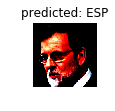

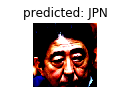

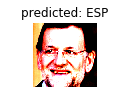

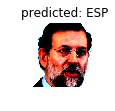

In [10]:
visualize_model(model = model,
                class_names = class_names,
                num_images = 6,
                dataloaders = dataloaders,
                use_gpu = use_gpu)

### Saving, loading, and using the trained model later

In [14]:
# - PyTorch comes with a function to easily save models
torch.save(model, '%s/MODELS/%s.pth'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)))

# - for a multiclass classifier, remember to also save the file indicating to which class
#   each class key corresponds to: the model returns the class number/key and not the class
#   label! Saving the class key-labels as a csv
model_class_key_labels = pd.DataFrame(
    {
        'label': class_names,
        'key': range(0, len(class_names))
    }
)
model_class_key_labels.to_csv('%s/MODELS/%s_labels.csv'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)),
                             index = False)

In [15]:
# - now reload the model again
model_new = torch.load(
    '%s/MODELS/%s.pth'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)))
# - and the class labels as well
class_labels = pd.read_csv('%s/MODELS/%s_labels.csv'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)))

In [16]:
# - load some example images to test how to use, on a new set of images, a model you previously trained
# ... e.g. read 5 images from the ESP test directory and 5 images from the USA test directory
esp_path = '%sworld_leaders/test/ESP/'%(DATA_PATH)
usa_path = '%sworld_leaders/test/USA/'%(DATA_PATH)
esp_img_test_path_list = ['%s%s'%(esp_path, x) for x in os.listdir(esp_path)[:5]]
usa_img_test_path_list = ['%s%s'%(usa_path, x) for x in os.listdir(usa_path)[:5]]
test_img_path_list = esp_img_test_path_list + usa_img_test_path_list
new_dataset = []
for img_file in test_img_path_list:
    img = Image.open(img_file).convert('RGB')
    new_dataset.append(img)

In [17]:
# - specifying the transformation-preprocessing to apply to the images
preprocess = data_tranform(train = False)

# - checking if the machine has GPUs and enabling GPU computing if so
use_gpu = torch.cuda.is_available()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [18]:
# - use the model to perform predictions on this "new" set of images
# ... initialize output dataset and a counter
output_data = pd.DataFrame()
counter = 0
total = len(new_dataset)
# ... iterate through the new images to predict
for z in range(0, len(new_dataset)):
    counter += 1
    print('image: %s/%s'%(counter, total))
    img_filename = test_img_path_list[z]
    img = new_dataset[z]
    # ... initialize output dict object for this iteration/img
    new_entry = {}
    # ... transform-preprocess this imags
    var = Variable(preprocess(img).unsqueeze(0))
    # ... make the model prediction
    pred = model_new(var.cuda())
    # ... pull the predicted class probabilities and create a dataframe with them
    probs, indeces = nn.Softmax(1)(pred).data.sort()
    probs = [round(x, 3) for x in list(probs[0][range(class_labels.shape[0])])]
    indeces = list(indeces[0][range(class_labels.shape[0])])
    labels = [class_labels.iloc[i]['label'] for i in indeces]
    pred_df = pd.DataFrame({'label':labels,
                            'probs':probs})
    pred_df_t = pred_df.transpose()
    final_pred_df = pd.DataFrame(pred_df_t.iloc[1]).transpose()    
    final_pred_df.columns = labels
    # ... adding some extra information about the image and prediction
    final_pred_df['img'] = '/'.join(img_filename.split('/')[-2:])
    final_pred_df['max_class'] = list(class_labels['label'])[indeces[len(class_labels)-1]]
    final_pred_df['max_pr'] = probs[len(class_labels)-1]
    output_data = pd.concat([output_data, final_pred_df])
output_data = output_data.reset_index(drop=True)

image: 1/10
image: 2/10
image: 3/10
image: 4/10
image: 5/10
image: 6/10
image: 7/10
image: 8/10
image: 9/10
image: 10/10


In [19]:
output_data

,ESP,JPN,KAZ,USA,VEN,ZAF,img,max_class,max_pr
0,0.925,0.009,0.033,0.009,0.013,0.011,ESP/esp_14_cropped.jpg,ESP,0.925
1,0.359,0.209,0.205,0.105,0.053,0.069,ESP/esp_11_cropped.jpg,ESP,0.359
2,0.761,0.056,0.047,0.056,0.045,0.035,ESP/esp_4_cropped.jpg,ESP,0.761
3,0.92,0.004,0.002,0.012,0.029,0.034,ESP/esp_30_cropped.jpg,ESP,0.920
4,0.894,0.005,0.05,0.02,0.016,0.015,ESP/esp_26_cropped.jpg,ESP,0.894
5,0.006,0.008,0.014,0.943,0.014,0.014,USA/usa_27_cropped.jpeg,USA,0.943
6,0.004,0.012,0.019,0.894,0.036,0.034,USA/usa_44_cropped.jpg,USA,0.894
7,0.001,0.026,0.053,0.895,0.014,0.011,USA/usa_8_cropped.jpg,USA,0.895
8,0.009,0.039,0.059,0.777,0.081,0.035,USA/usa_11_cropped.jpg,USA,0.777
9,0.01,0.012,0.012,0.758,0.037,0.171,USA/usa_23_cropped.jpg,USA,0.758
